# Real or Not? NLP with Disaster Tweets

For this notebook we have drawn some inspirations from the following notebooks:

* NLP with Disaster Tweets - EDA, Cleaning and BERT.ipynb
* Disaster NLP: Keras BERT using TFHub

*   Disaster Tweets Evaluation with NLP .ipynb




**Problem/Challenge to be solved:**

This project is based on a kaggle competition (www.kaggle.com/c/nlp-getting-started) aiming at analysing tweets and determining if they are related to a disaster or not. To perform this analysis, we were provided  three datasets: train.csv, test.csv and sample_submission.csv. Using Natural Language Processing (NLP) we aim at analysing the tweets and predicting their context. Please not that the aim of this notebook is not to provide state-of-the-art model. NLP is a new topic for all of us, so the objective of this notebook and our project is to experiment with different approaches to Natural Language Processing and gain some experience.

**Project approach:**
<br>
<br>
As a fist step, our team will make exploratory data analysis, in order to identify the trends in the data which might be useful to create new features, clean the tweets from unnecessary elements. 
<br>
<br>
Second step will be to clean the data, create additional columns with features. Then, we will tokenize the tweets (and their parts). This will serve as an input into the neural networks and ML classification models.
<br>
<br>
As a third step, we will train and evaluate several ML learning models and two neural networks. For the top-performing ML models we will tune the hyperparameters. Afterwards, we will re-evaluate the best models (for which we tuned the parameters), compare their performance and choose the best model.
<br>
<br>
As a final step, we will execute the best model on the test set and save the predictions in the submission file.

**Final End Results**

To obtain final predictions for test set, we have built multiple models using different algorithms, including: Logistic Regression, Linear Discriminant Analysis, K-Nearest Neighbors, Naïve Bayes, CART, Support Vector Machines, Random Forest, Extra Trees, XGBoost and Neural Network. We have also tuned hyperparameters to further improve the accuracy.
<br>
<br>
We have tried using also pretrained neural network – BERT – to overcome the problem of relatively small dataset. However, we’ve encountered problems with our computing power and we didn’t manage to run it on our computers.
<br>
<br>
Finally, we have chosen XGBoost as the most accurate and stable model, and we calculated predictions for target variable for test set. The average accuracy for XGBoost using cross-validation was 76%. The algorithm definitely isn’t state-of-the-art. However, our main objective, which we have fulfilled, was to gain more knowledge and practical experience with NLP, as it was our first project with this type of problem to be solved.


**Team Members:** 

Natalia Korchagina

Aleksandra Sledziewska

Lucas Revereault

# Import Packages


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import string
from collections import defaultdict
import re

# Code to access drive to retrieve csv files
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Files


Note: For this part I imported the files directly from the google drive using PyDrive

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Importing train.csv

In [ ]:
id_train = '16PHMhtVaNuUMDpEBdVfOllR7f8kDFdDC'
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train.csv')  
train = pd.read_csv('train.csv')
train = train.set_index('id')
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Importing test.csv

In [ ]:
id_test = '1dzsPZqTCbXG2z8b_nlnBhr6ab2xUXou2'
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test.csv')  
test = pd.read_csv('test.csv')
test = test.set_index('id')
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Importing sample_submission.csv

In [ ]:
id_sample_submission = '1o8uWCklhWfqs8QEBAtuorrzXzVBMnRx0'
downloaded = drive.CreateFile({'id':id_sample_submission}) 
downloaded.GetContentFile('sample_submission.csv')  
sample_submission = pd.read_csv('sample_submission.csv')
#sample_submission.head()

*Note: this csv file is just an example of the submission format. Therefore we will not explore the file any further*

# Exploratory Data Analysis


### Datasets shape

Both train and test sets are indexed by the unique identifier for each tweet, and contain columns with information about keywords from the tweet, location from which the tweet was sent, and text of the tweet. Moreover, train set contains a column with binary target variable - 1 if tweet is about real disaster, 0 if not. Our goal is to predict target variable for test set.

Train set contains 7613 entries (tweets), while test set - 3263. Around 43% of tweets in training set are real disaster tweets, so it is a balanced dataset.

In [ ]:
# Check dimensions and columns of training dataset
train.shape
print()
train.columns

(7613, 4)

Index(['keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
# Check dimensions and columns of test dataset
test.shape
print()
test.columns

(3263, 3)

Index(['keyword', 'location', 'text'], dtype='object')

Text(0.5, 1.0, 'Distribution of target variable')

Text(0, 0.5, 'count')

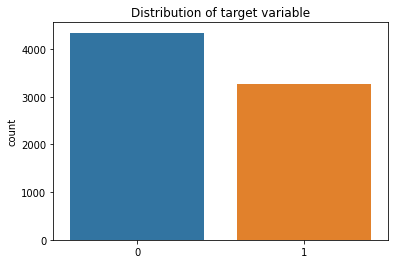

In [ ]:
# Plot the number of disaster tweets vs non-disaster tweets
x=train.target.value_counts()
sns.barplot(x.index,x).set_title("Distribution of target variable")
plt.gca().set_ylabel('count')

In [ ]:
# Calculate the percentage of real disaster tweets
train['target'].mean()

0.4296597924602653

### Data types

Data types contained in the dataset are mostly objects with free text and integer for target variable in training set (binary variable).

In [ ]:
print("Training set data types")
train.dtypes
print()
print()

print("Test set data types")
test.dtypes

Training set data types


keyword     object
location    object
text        object
target       int64
dtype: object



Test set data types


keyword     object
location    object
text        object
dtype: object

### Missing values

Both in the training and test set there are around 33% of missing values for `location`, and less than 1% for `keyword`. There are no missing values for text and target variables.

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

Text(0.5, 1.0, 'Missing values in Training set')

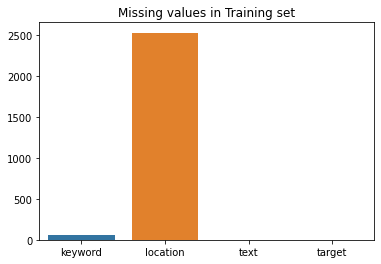

In [ ]:
# Plot missing values in Training set
train.isnull().sum()/len(train.index)
print()
sns.barplot(x=train.isnull().sum().index, y=train.isnull().sum().values).set_title('Missing values in Training set')

keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

Text(0.5, 1.0, 'Missing values in Test set')

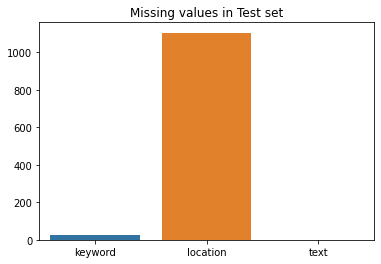

In [ ]:
# Plot missing values in Test set
test.isnull().sum()/len(test.index)
print()
sns.barplot(x=test.isnull().sum().index, y=test.isnull().sum().values).set_title('Missing values in Test set')

### Keywords

Based on the distribution of keywords we can see that some of the keywords are used practically entirely for disaster tweets or non-disaster tweets. `Keyword` variable may be therefore useful for predicting the `target` variable.

In [ ]:
# count number of unique keywords
train['keyword'].nunique()

221

Text(0.5, 1.0, 'Target Distribution in Keywords')

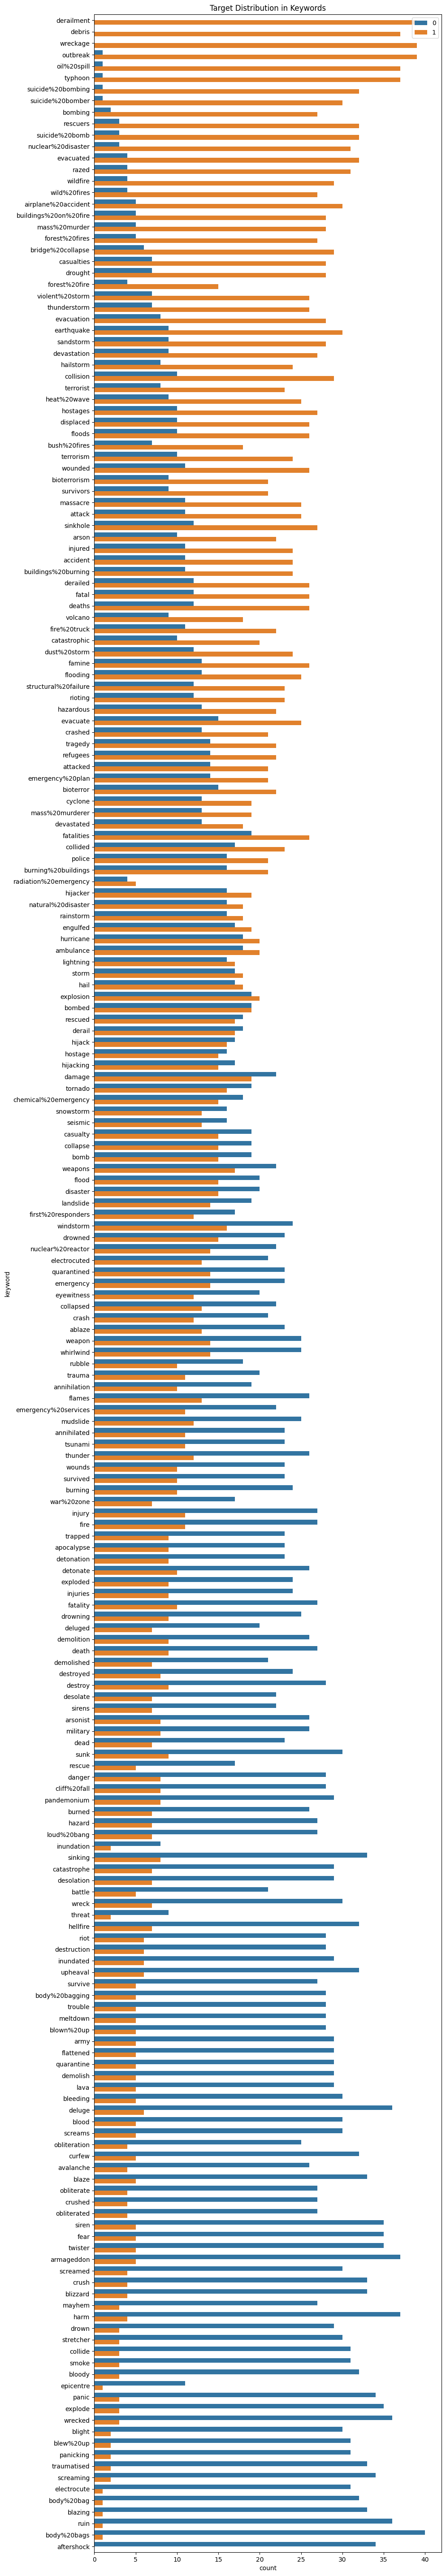

In [ ]:
# Plot keywords appearing in disaster vs non-disaster tweets
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(10, 75), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target']).set_title("Target Distribution in Keywords")
plt.legend(loc=1)

train.drop(columns=['target_mean'], inplace=True)

### data exploration conclusion
 After doing some data exploration, we could describe the dataset as rather small, well balanced, and containing useful information like 'keywords'. We have also seen that the 'location' information has a lot of missing data. Next we will extract more information from the'text' column and proceed with some data cleaning for our model. 

# Data Preprocessing & Feature Engineering


### Word importance

In the following part we will experiment with different variables which can be useful for prediciting whether a tweet is a about a real disaster or not. Afterward, we will verify which of them have high importance in predicting the output.

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [ ]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

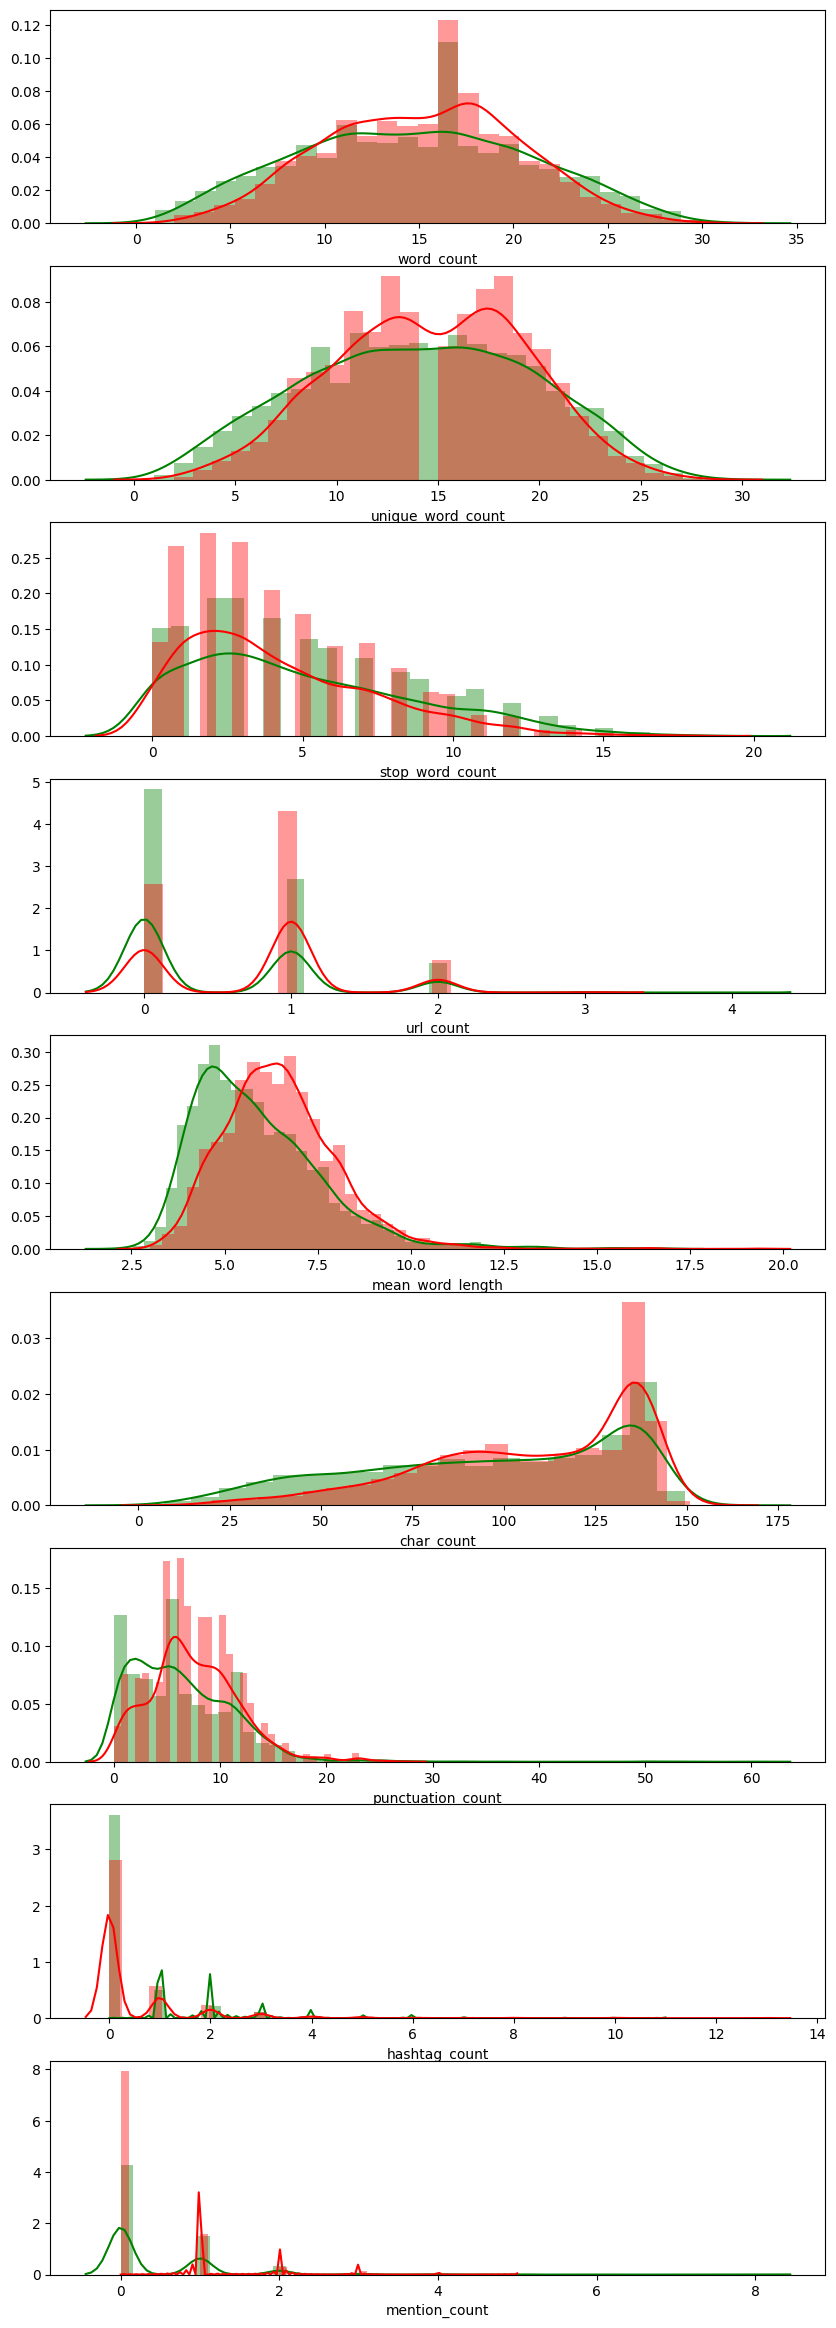

In [ ]:
# Plot the distributions of features created above for target 0 and 1

new_features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

fig, axes = plt.subplots(nrows=len(new_features), figsize=(10, 30), dpi=100)

for i, feature in enumerate(new_features):
    sns.distplot(train.loc[train['target'] == 0][feature], ax=axes[i], label='Not Disaster', color='green')
    sns.distplot(train.loc[train['target'] == 1][feature], ax=axes[i], label='Disaster', color='red')

### N-grams

N-grams are a sequence of n items, where 1-grams, called Unigrams, would be one word, Bigrams two word, etc.. N-grams are used to identify words or sentence in a text. Here we will use them to determine the most frequently used unigrams, Bigrams and Trigrams

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in [*STOPWORDS, *list(string.punctuation), "'", "`"]]
    # do not count tokens for stopwords and punctuation signs
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

In [ ]:
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[train['target'] == 0]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[train['target'] == 0]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[train['target'] == 0]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

#### Unigrams

Text(0.5, 1.0, 'Top 20 most common unigrams in Disaster Tweets')

Text(0.5, 1.0, 'Top 20 most common unigrams in Non-disaster Tweets')

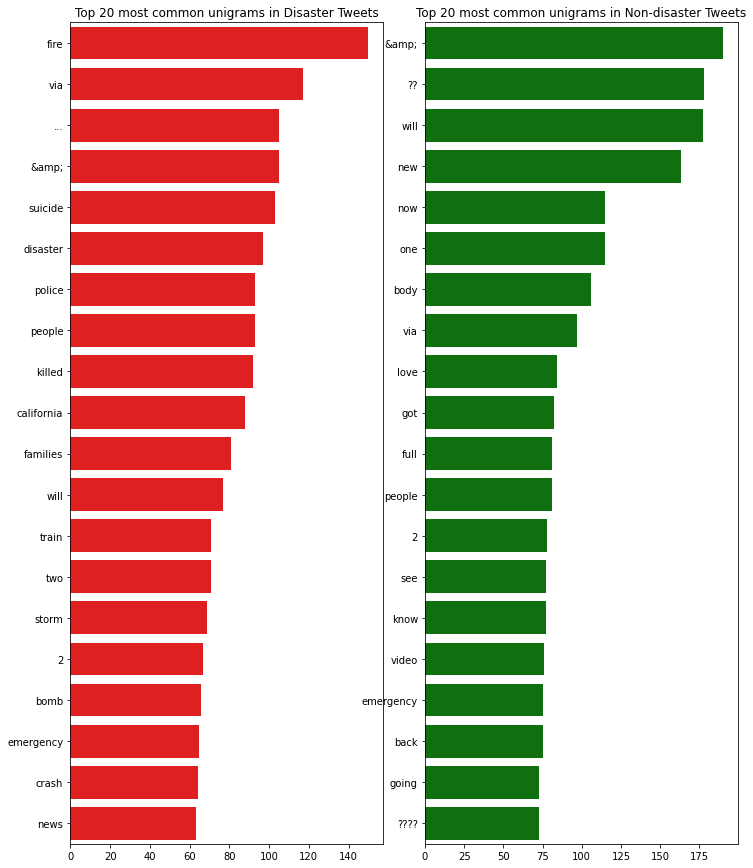

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 12))
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:20], x=df_disaster_unigrams[1].values[:20], ax=axes[0], color='red').set_title('Top 20 most common unigrams in Disaster Tweets')
sns.barplot(y=df_nondisaster_unigrams[0].values[:20], x=df_nondisaster_unigrams[1].values[:20], ax=axes[1], color='green').set_title('Top 20 most common unigrams in Non-disaster Tweets')

#### Bigrams

Text(0.5, 1.0, 'Top 20 most common bigrams in Disaster Tweets')

Text(0.5, 1.0, 'Top 20 most common bigrams in Non-disaster Tweets')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


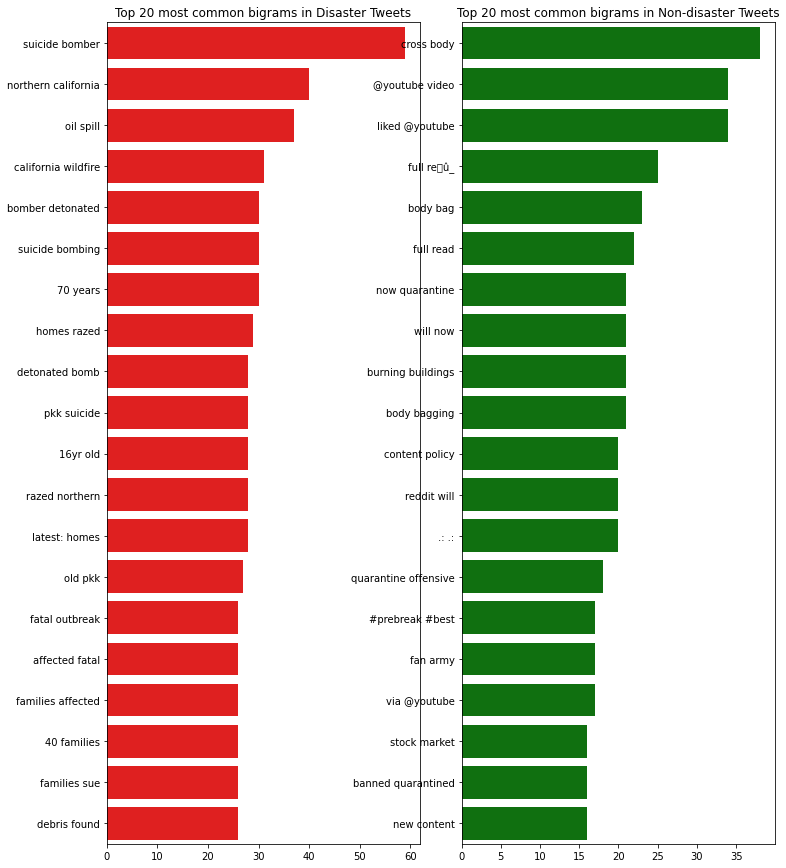

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 12))
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:20], x=df_disaster_bigrams[1].values[:20], ax=axes[0], color='red').set_title('Top 20 most common bigrams in Disaster Tweets')
sns.barplot(y=df_nondisaster_bigrams[0].values[:20], x=df_nondisaster_bigrams[1].values[:20], ax=axes[1], color='green').set_title('Top 20 most common bigrams in Non-disaster Tweets')

#### Trigrams

Text(0.5, 1.0, 'Top 20 most common trigrams in Disaster Tweets')

Text(0.5, 1.0, 'Top 20 most common trigrams in Non-disaster Tweets')

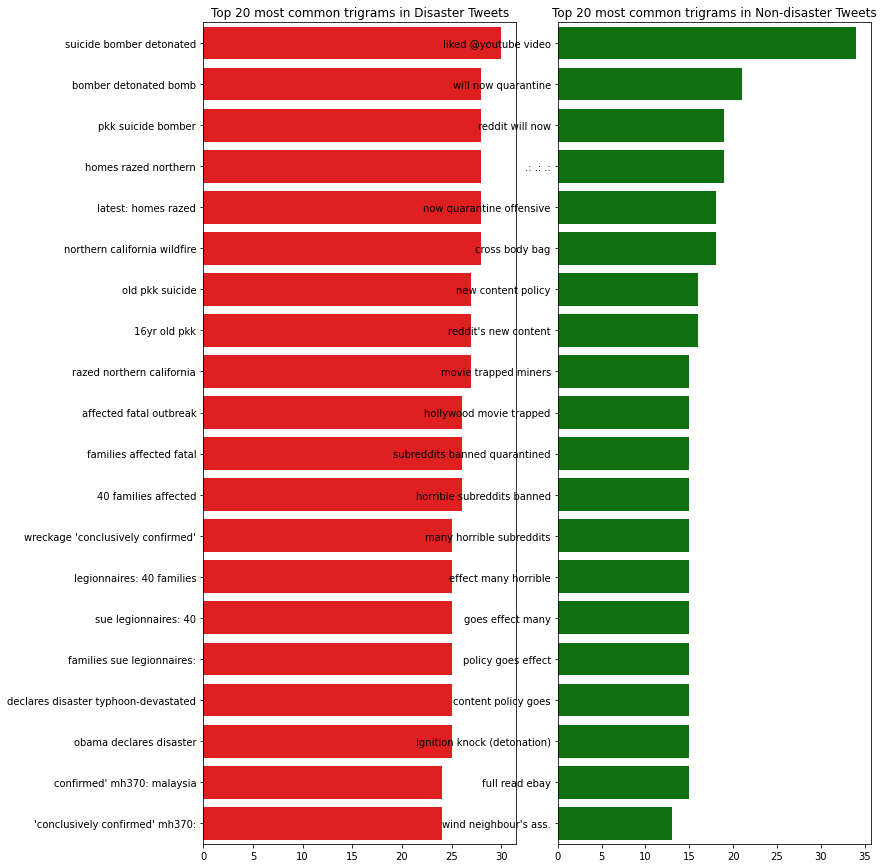

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 12))
plt.tight_layout()

sns.barplot(y=df_disaster_trigrams[0].values[:20], x=df_disaster_trigrams[1].values[:20], ax=axes[0], color='red').set_title('Top 20 most common trigrams in Disaster Tweets')
sns.barplot(y=df_nondisaster_trigrams[0].values[:20], x=df_nondisaster_trigrams[1].values[:20], ax=axes[1], color='green').set_title('Top 20 most common trigrams in Non-disaster Tweets')

### Text Cleaning

By plotting the N-grams, we saw that the tweets need to be cleaned from unnecessary words and expressions which have no connection with the content of the message (e.g. &amp, @youtube video and etc.) Thus, in this section we will clean the data from this vocabulary / rephrase the typos, slang and informal expressions.

In [ ]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

train['text_cleaned'] = train['text'].apply(lambda s : clean(s))
test['text_cleaned'] = test['text'].apply(lambda s : clean(s))

Let's extract hashtags, mentions and links from the text

In [ ]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    #df['hashtags'].fillna(value='no', inplace=True)
    #df['mentions'].fillna(value='no', inplace=True)
    #df['links'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

Now let's clean the location column. First, we want to see which errors and typos are common in the dataset, so that we can eliminate them.

In [ ]:
# Check number of unique keywords and locations
print (train.location.unique(), test.location.unique())

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln'] [nan 'London' "Niall's place | SAF 12 SQUAD |" ...
 'Acey mountain islanddåÇTorontoåÈ' 'los angeles' 'Brussels, Belgium']


So we see that location column in both sets (test and train) requires transformation. Considering the fact that the process of transformation is timeconsuming, we will aplly transformation only to the most common locations.

<Figure size 1008x432 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

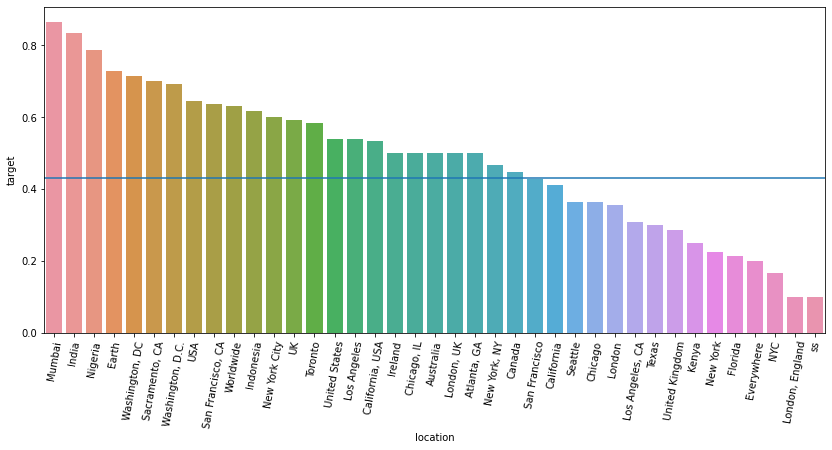

In [ ]:
#Let's look what are the most mentioned locations in the tweets
raw_loc = train.location.value_counts()
#Store the most frequently mentioned locations to the list
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

We see that the locations which are most frequently mentioned are Mumbai, India and Nigeria.


After checking the location names in both files, we saw that some locations, for example, "London" are counted twice because of a) spaces in the names, b) wording (e.g. London, London UK) c) typos. Which is why, the next step will be to eleminate these 'defects' and transform the text to the unified form.

In [ ]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

In [ ]:
train.location_clean.unique()

array(['None', 'Others', 'London', 'India', 'USA', 'San Francisco', 'UK',
       'Australia', 'Kenya', 'Canada', 'Texas', 'Indonesia', 'Mumbai',
       'Toronto', 'New York', 'California', 'Florida', 'World',
       'Washington DC', 'Los Angeles', 'Chicago', 'ss', 'Atlanta',
       'Ireland', 'Seattle', 'Nigeria', 'Sacramento'], dtype=object)

## Feature Engineering

As part of feature generation, we will:



*   Apply target encoding to keyword and location (cleaned)
*   Count Vectorize cleaned text, links, hashtags and mentions columns



In [ ]:
#Install category_encoders library if necessary
!pip install category_encoders

     |████████████████████████████████| 81kB 4.7MB/s 


In [ ]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

TargetEncoder(cols=['keyword', 'location_clean'], drop_invariant=False,
              handle_missing='value', handle_unknown='value',
              min_samples_leaf=1, return_df=True, smoothing=1.0, verbose=0)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


Now let's apply TF-IDF transformations for the cleaned text. We will leave only those words, which appear in at least 10 tweets and are part of unigrams or bigrams.

In [ ]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_cleaned'])
text_vec_test = vec_text.transform(test['text_cleaned'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1732)


In [ ]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1883) (3263, 1882)


Now our data is prepared, so that we can start training and testing the models.

# Training and testing the models

### 1. Logistic regression

In [ ]:
#Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#Transform the tables (delete unnecessary columns)
features_to_drop = ['keyword','location','text','location_clean','text_cleaned', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target']).fillna(0)
X_test = test.drop(columns = features_to_drop).fillna(0)
y_train = train.target

In [ ]:
# scale values in the dataframe to be in the same range
#scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)
#y_train = train.target

In [ ]:
# Create the DataFrames for plotting the results
resall=pd.DataFrame()
res=pd.DataFrame()

In [ ]:
#Run and evaluate the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=10)

model = LogisticRegression(solver="liblinear")

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Logistic Regression - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="LogReg"

resall = pd.concat([resall,res], ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression - Accuracy 75.226% std 2.805692


### 2. Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Linear Discriminant Analysis - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="LDA"

resall = pd.concat([resall,res], ignore_index=True)

### 3. K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'KNN - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="KNN"

resall = pd.concat([resall,res], ignore_index=True)

KNN - Accuracy 67.516% std 5.493583


### 4. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Naive Bayes - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="Naive Bayes"

resall = pd.concat([resall,res], ignore_index=True)

Naive Bayes - Accuracy 50.084% std 5.215477


### 5. CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight="balanced", random_state=10)

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Decision Tree - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="Decision Tree"

resall = pd.concat([resall,res], ignore_index=True)

Decision Tree - Accuracy 68.672% std 3.026138


### 6. Support Vector Machines

In [ ]:
from sklearn.svm import SVC

model = SVC(gamma="scale")

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Support Vector Machines - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res["Res"]=results
res["Type"]="SVM"

resall = pd.concat([resall,res], ignore_index=True)

Support Vector Machines - Accuracy 75.292% std 3.653911


### 7. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

num_trees=100
num_features=20

model=RandomForestClassifier(n_estimators=num_trees, max_features=num_features, random_state=10)

results=cross_val_score(model, X_train, y_train, cv=kfold)

print(f'Random Forest - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res["Res"]=results
res["Type"]="Random Forest"

resall=pd.concat([resall,res], ignore_index=True)

Random Forest - Accuracy 75.239% std 2.617937


### 8. Extra trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees=300
num_features=20

model=ExtraTreesClassifier(n_estimators=num_trees, max_features=num_features, random_state=10)

results=cross_val_score(model, X_train, y_train, cv=kfold)

print(f'Extra Trees - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res["Res"]=results
res["Type"]="Extra Trees"

resall=pd.concat([resall,res], ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extra Trees - Accuracy 74.569% std 2.966465


### 9. XGBoost

In [ ]:
import xgboost as xgb

learner=xgb.XGBClassifier()

results=cross_val_score(learner, X_train, y_train, cv=kfold)

print(f'XGBoost - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res["Res"]=results
res["Type"]="XGBoost"

resall=pd.concat([resall,res], ignore_index=True)

XGBoost - Accuracy 76.054% std 2.737228


### Algorithms Comparison

<Figure size 1080x648 with 0 Axes>

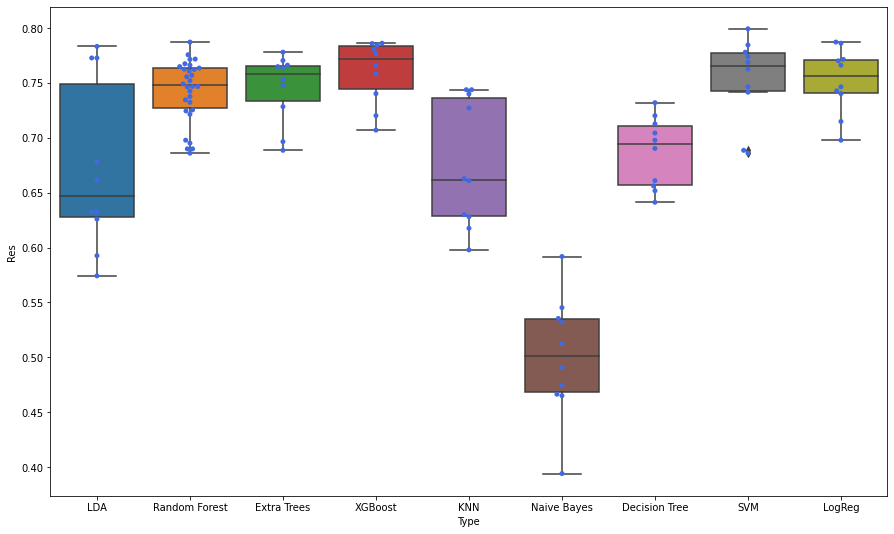

In [ ]:
# Compare all the algoriths on a plot
plt.figure(figsize=(15,9))

sns.boxplot(data=resall, x="Type", y="Res")
sns.swarmplot(data=resall, x="Type", y="Res", color="royalblue")

The analysis of the models' performance has show that the most promising models are Random Forest, Extra Trees, XGBoost, SVM and Logistic Regression. XGBoost is the best model so far. 
Our next step will be to try hyperparameter tuning to further improve accuracy, so that we can choose the best model with best combination of the parameters.

# Hyperparameters tuning

In [ ]:
##### Logistic Regression - hyperparameter tuning


# from sklearn.model_selection import GridSearchCV

# model = LogisticRegression(solver="liblinear")

# param_grid = {"max_iter":[10,20,30,40,50], "C":[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2]}

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
# grid_result = grid.fit(X_train_sc, y_train)

# print(f'Grid Best Score {grid_result.best_score_:.7f} \
#       Maximum number of iterations {grid_result.best_params_["max_iter"]} \
#       C- regularization strength {grid_result.best_params_["C"]}')
# print()

# Grid Best Score 0.7556777       Maximum number of iterations 10       C- regularization strength 0.6

In [ ]:
##### Random Forest - hyperparameter tuning


# model = RandomForestClassifier()

# param_grid = {"n_estimators": [50,100,150,200], "max_features":[10,20,30,40,50,60,80,100], "max_depth": [10,20,30,40,50]}

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
# grid_result = grid.fit(X_train_sc, y_train)

# print(f'Grid Best Score {grid_result.best_score_:.7f} \
#       Number of trees {grid_result.best_params_["n_estimators"]} \
#       Maximum number of features {grid_result.best_params_["max_features"]} \
#       Maximum depth of trees {grid_result.best_params_["max_depth"]}')
# print()

# Grid Best Score 0.7597506       Number of trees 100       Maximum number of features 80       Maximum depth of trees 40

## Running top-performing models with new parameters

In [ ]:
# Create the DataFrames for plotting the results
resall_2=pd.DataFrame()
res_2=pd.DataFrame()

### Logistic Regression

In [ ]:
#Maximum number of iterations 10       C- regularization strength 0.6
model = LogisticRegression(C=0.6, solver="liblinear", max_iter=10)

results = cross_val_score(model, X_train_sc, y_train, cv=kfold)

print(f'Logistic Regression - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

# save the results
res_2["Res"]=results
res_2["Type"]="LogReg"

resall_2 = pd.concat([resall_2,res_2], ignore_index=True)

Logistic Regression - Accuracy 75.568% std 2.749432


### Random Forest

In [ ]:
#Number of trees 100       Maximum number of features 80       Maximum depth of trees 40
num_trees=100
num_features=80
depth=40

model=RandomForestClassifier(n_estimators=num_trees, max_depth=depth, max_features=num_features, random_state=10)

results=cross_val_score(model, X_train, y_train, cv=kfold)

print(f'Random Forest - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res_2["Res"]=results
res_2["Type"]="Random Forest"

resall_2=pd.concat([resall_2,res_2], ignore_index=True)

Random Forest - Accuracy 75.804% std 2.669276


### Compare results

In [ ]:
resall_2=pd.concat([resall_2,resall[resall['Type']=='XGBoost']], ignore_index=True)
resall_2=pd.concat([resall_2,resall[resall['Type']=='SVM']], ignore_index=True)

In [ ]:
resall_2=pd.concat([resall_2,resall[resall['Type']=='Extra Trees']], ignore_index=True)

<Figure size 1080x648 with 0 Axes>

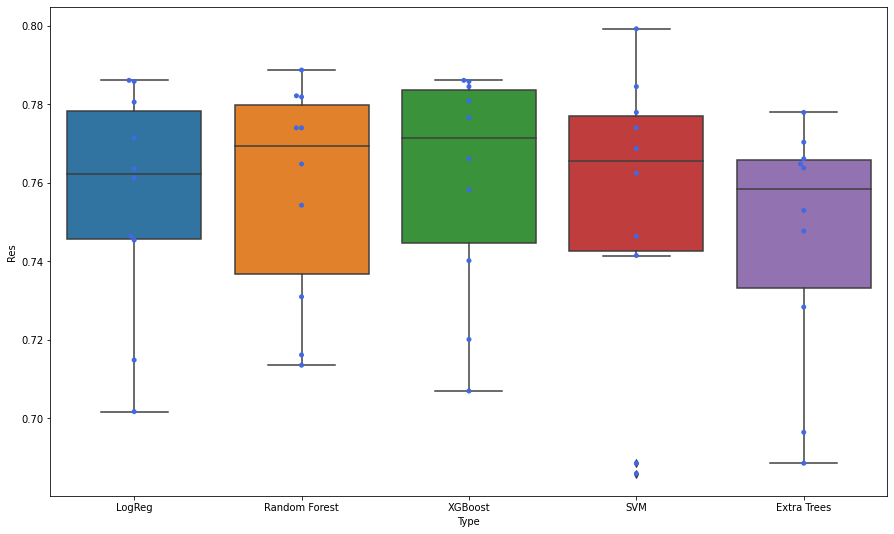

In [ ]:
# Compare all the algoriths on a plot
plt.figure(figsize=(15,9))

sns.boxplot(data=resall_2, x="Type", y="Res")
sns.swarmplot(data=resall_2, x="Type", y="Res", color="royalblue")

From the plot above we can see that ven after hyperparameters tuning for some models, XGBoost model is still the best in terms of accuracy, compared to others.

### 10. Neural Network

We also wanted to build a neural network to see how it performs in comparison with other algorithms. Below we present an exemplary neural net.

However, our dataset is too small (only 7600 entries) to build a reliable neural network from scratch, and we obtain lower accuracy than for other models.

In [ ]:
# split the training dataset into 2 sets to be able to assess accuracy of neural net
from sklearn.model_selection import train_test_split

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_train_sc, y_train, test_size=0.2, random_state=10)

In [ ]:
# Build a neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(40, input_dim=1874, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 40)                75000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 40)                160       
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 21        
Total params: 76,001
Trainable params: 75,921
Non-trainable params: 80
_________________________________________________

In [ ]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_nn, Y_train_nn, epochs=50, batch_size=64)

Epoch 1/50
96/96 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6542
Epoch 2/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5753 - accuracy: 0.7072
Epoch 3/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5509 - accuracy: 0.7258
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5412 - accuracy: 0.7348
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5344 - accuracy: 0.7340
Epoch 6/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5270 - accuracy: 0.7484
Epoch 7/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.7494
Epoch 8/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5086 - accuracy: 0.7542
Epoch 9/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5088 - accuracy: 0.7481
Epoch 10/50
96/96 [==============================] - 0s 3ms/step - loss: 0.5110 - accuracy: 0.7509
Epoch 11/50
96/96 [

In [ ]:
model.evaluate(X_test_nn, Y_test_nn, batch_size=64)

24/24 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7466


[0.5916947722434998, 0.7465528845787048]

### 11. BERT model

We wanted to find pretrained neural network to apply it to our problem. We've found out that BERT can be used in our case.

Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP (Natural Language Processing) pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google. Google is leveraging BERT to better understand user searches.

Unfortunately, with our available computing power we weren't able to run this algorithm. The computer ran out of RAM or it took extremely long to process. Therefore, we just provide the code below, however, we didn't manage to process the whole neural network.

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install sentencepiece

In [ ]:
# import libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text_cleaned.values, tokenizer, max_len=100)
test_input = bert_encode(test.text_cleaned.values, tokenizer, max_len=100)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=100)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
# # save model weights at checkpoints
# checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

# # train the model
# train_history = model.fit(
#     train_input, train_labels,
#     validation_split=0.2,
#     epochs=3,
#     callbacks=[checkpoint],
#     batch_size=128
# )

Epoch 1/3


In [ ]:
# model.load_weights('model.h5')
# test_pred = model.predict(test_input)

In [ ]:
# submission['target'] = test_pred.round().astype(int)
# submission.to_csv('submission.csv', index=False)

# Providing predictions for the test set

As XGBoost proved to be the best model, we will use it to provide predictions for the test set.

In [ ]:
learner = xgb.XGBClassifier()
learner.fit(X_train, y_train)
preds = learner.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
result = pd.DataFrame({'id':list(X_test.index), 'target':preds})

In [ ]:
result.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,0
5,12,0
6,21,1
7,22,0
8,27,0
9,29,0


In [ ]:
result.to_csv("submission.csv", index=False)